In [1]:
import emcee, copy
import numpy as np
from astropy.table import Table,Column
import matplotlib.pyplot as plt
from astropy.io import ascii

  MJD            lum           ...        Mbolerr         t_exp 
------- ---------------------- ... --------------------- -------
  15.19 2.2496933248455278e+42 ...  0.002396120766181761   15.19
 16.197   2.19188616323807e+42 ...  0.002182445229133019  16.197
 17.204 2.1485929072710078e+42 ...   0.00223358222077579  17.204
 18.211   2.15485988821914e+42 ... 0.0023972781869347174  18.211
 19.218  2.108393023024231e+42 ...  0.002541165784444164  19.218
 20.224  2.075986689948209e+42 ...   0.00247815082627638  20.224
 21.231  2.030982034183352e+42 ... 0.0025549748878595413  21.231
 22.238  2.019932691946303e+42 ... 0.0028205451101044453  22.238
 23.245  1.975704374075622e+42 ...  0.003231787316849731  23.245
 24.251 1.9457686014810535e+42 ... 0.0030314786832908477  24.251
    ...                    ... ...                   ...     ...
119.895 1.5134575842750611e+41 ...  0.015253639425069871 119.895
120.902  1.428346433392599e+41 ...  0.015725254927698832 120.902
121.909  1.34802164819607

100%|██████████| 5000/5000 [02:22<00:00, 35.18it/s]


Best-fit parameters:
Param: 2.4134758578130517 + 0.13511115574385135 - 0.12009251381617725
Param: 107.67107385175521 + 0.8677025636210374 - 0.7970213835693585
Param: 8.619708085494734 + 0.675097549560169 - 0.6105830483449335
Param: 0.008896819195510821 + 0.0007285670923600478 - 0.0007484435716536078
Param: -14.794010182836296 + 0.15820845730524624 - 0.14495386722253656
[2.4134758578130517, 107.67107385175521, 8.619708085494734, 0.008896819195510821, -14.794010182836296]
  MJD            lum           ...        Mbolerr         t_exp 
------- ---------------------- ... --------------------- -------
  15.19 2.2496933248455278e+42 ...  0.002396120766181761   15.19
 16.197   2.19188616323807e+42 ...  0.002182445229133019  16.197
 17.204 2.1485929072710078e+42 ...   0.00223358222077579  17.204
 18.211   2.15485988821914e+42 ... 0.0023972781869347174  18.211
 19.218  2.108393023024231e+42 ...  0.002541165784444164  19.218
 20.224  2.075986689948209e+42 ...   0.00247815082627638  20.224
 21.2

<Figure size 640x480 with 0 Axes>

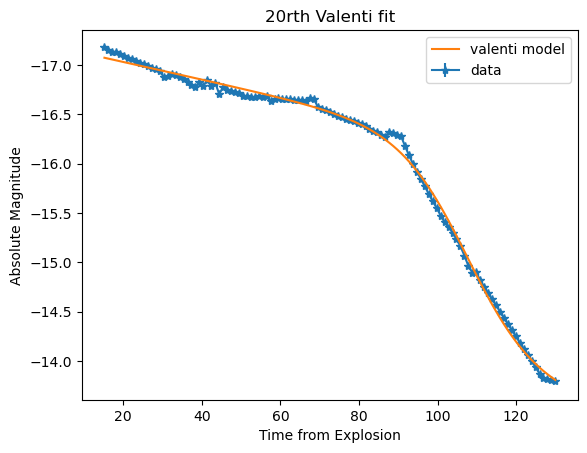

In [2]:
plt.clf()

# Input parameters - superbol file and MJD explosion/discovery date
data_file='rth_bol_LC'
mjd_start=0

def valenti_model(time, theta):
    a, tpt, w, p, m = theta
    return(-a/(1. + np.exp((time-tpt)/w))+p*time+m)

def lnlikelihood(theta, lum, dlum, time):
    model_lum = valenti_model(time, theta)
    
    # Set parameter range value
    a, tpt, w, p, m = theta
    if a<0.01: return(-np.inf)
    if a>10.0: return(-np.inf)
    if tpt<10.0: return(-np.inf)
    if w<0.01: return(-np.inf)
    
    inv_sigma = 1./dlum**2
    return(-0.5 * np.sum((lum-model_lum)**2 * inv_sigma))

def load_table(data_file, mjd_start=mjd_start, mask_date=15):
    # The code will automatically mask data mask_date days from the input reference date.
    # Change this value in order to adjust the amount of data that's included/excluded
    
    table = Table.read(data_file, format='ascii',names=('MJD','lum','dlum'))
    #print(table)
    # Want to fit versus a magnitude rather than actual luminosity, so convert lum to Mbol
    # Here 83.9605452803 = 2.5*log10(3.839e33) for Solar luminosity
    # 4.74 is bolometric luminosity of the Sun
    table['MJD'] = table['MJD']
    Mbol = -2.5*np.log10(table['lum']) + 83.9605452803 + 4.74
    Mbolerr = 1.086 * (table['dlum'] / table['lum'])

    
    table.add_column(Column(Mbol, name='Mbol'))
    table.add_column(Column(Mbolerr, name='Mbolerr'))
    
    newcol=Column(table['MJD'].data-mjd_start,name='t_exp')
    table.add_column(newcol)
    
    mask = table['t_exp']>mask_date
    table=table[mask]
    print(table)
    return(table)

def mcmc_valenti(data_file, ndim=5, nwalkers=100, inflate_errors=0.1):
    
    # I'm adding a parameter to inflate the error bars because the code appears to underfit the
    # late time decline due to nickel, which is primarily what we're interested in
    
    params = [1.7391707763335567, 111.06179709805089, 7.203197652533321, 0.008194307783125725, -13.583601384015793]
    pos = [params + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
    
    table = load_table(data_file)
    mask = np.abs(table['MJD'] - mjd_start) < 1
    table = table[~mask]
    table['Mbolerr'] = np.sqrt(table['Mbolerr']**2+inflate_errors**2)
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlikelihood, 
                                    args=(table['Mbol'],
                                          table['Mbolerr'],
                                          table['t_exp']))
    
    sampler.run_mcmc(pos, 5000, progress=True)
    samples = sampler.chain[:, 99:, :].reshape((-1, ndim))
    
    return(samples)

def get_param_uncertainties(samples):
    
    vals = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                 zip(*np.percentile(samples, [16, 50, 84],
                                                    axis=0)))
    
    vals = [v for v in vals]
    
    return(vals)
    
samples=mcmc_valenti(data_file)
params=get_param_uncertainties(samples)
   

print('Best-fit parameters:')
for p in copy.copy(params):
    print('Param: {0} + {1} - {2}'.format(p[0], p[1], p[2]))

best_fit=[p[0] for p in copy.copy(params)]
print(best_fit)
table = load_table(data_file)
plt.figure() 

plt.errorbar(table['MJD']-mjd_start, table['Mbol'], yerr=table['Mbolerr'], marker='*', zorder=5, label = 'data')

    
model_lum=valenti_model(table['MJD']-mjd_start, best_fit)

plt.plot(table['MJD']-mjd_start, model_lum, zorder=10, label = 'valenti model')

#plt.ylim([-14,-20])
plt.ylabel('Absolute Magnitude')
plt.xlabel('Time from Explosion')
plt.legend()
plt.title('20rth Valenti fit')
plt.gca().invert_yaxis()

plt.show()

In [3]:
luminosity=[]
# Using 110.0 rest-frame days as reference time
lightcurve_ref_time = 110-mjd_start
print(lightcurve_ref_time)
for s in samples:
    abs_mag=valenti_model(lightcurve_ref_time, s)
    luminosity.append(3.839e33 * 10**(-0.4 * (abs_mag-4.74)))

data = np.percentile(luminosity, [16, 50, 84])
lum=data[1]
errhi=data[2]-data[1]
errlo=data[1]-data[0] 
print('Luminosity (1e39 erg/s)=','%1.2f'%(lum*1.0e-39),'+','%1.2f'%(errhi*1.0e-39),'-','%1.2f'%(errlo*1.0e-39))
print(data) 
print(errhi)
print(errlo)

# Heating rate for Co-56 decay in erg/s/g
epsilon = 6.8e9
# Mass of Co-56 in grams at 270 days
mass_Co56 = np.array(luminosity) / epsilon

# Radioactive decay timescale for Ni-56 and Co-56.  These are equal to ln(2)/(half-life)
# Half-life for Ni-56 is 6.075 days, Half-life for Co-56 is 55.93983 days
lambda_Co56 = np.log(2)/55.9383
lambda_Ni56 = np.log(2)/6.075

# Mass of Ni-56 at t=0
mass_Ni56 = mass_Co56 * (lambda_Co56 - lambda_Ni56)/lambda_Ni56 * (np.exp(-lambda_Ni56 * lightcurve_ref_time) - np.exp(-lambda_Co56 * lightcurve_ref_time))**-1
data = np.percentile(mass_Ni56, [16, 50, 84])
print(data)
mass=data[1]
errhi=data[2]-data[1]
errlo=data[1]-data[0] 
print('Mass (Msun)=','%1.4f'%(mass/(1.989e33)),'+','%1.4f'%(errhi/(1.989e33)),'-','%1.4f'%(errlo/(1.989e33)))

110
Luminosity (1e39 erg/s)= 265.74 + 6.73 - 6.66
[2.59088714e+41 2.65744609e+41 2.72470588e+41]
6.725979406512061e+39
6.65589469053345e+39
[1.32732869e+32 1.36142728e+32 1.39588492e+32]
Mass (Msun)= 0.0684 + 0.0017 - 0.0017


In [4]:
def erg(x):
    Lsun = 3.838e33 #erg/s
    L = Lsun * 10 ** (0.4 *(4.74 - x))
    return L 

In [5]:
def abs_mag(x):
   Mbol_sun = 4.74 
   log_L_sun = 83.9605452803 # - 2.5 * log10(3.838e33)
   Mbol = -2.5 * x['lum'] + log_L_sun + Mbol_sun
   return Mbol  

In [6]:
sn87a = table.read('1987A.dat', format = 'ascii', names = ('MJD', 'lum', 'dlum')) 
Mbol_87a = abs_mag(sn87a)

In [7]:
rth_interp = np.interp(110, table['MJD'], table['Mbol'])
rth_L = erg(rth_interp)
sn87a_interp = np.interp(110, sn87a['MJD'], Mbol_87a)
sn87a_L = erg(sn87a_interp)

In [8]:
Ni_87a = 0.075 
Ni_rth = Ni_87a * (rth_L / sn87a_L)
Ni_rth

0.08016470554650691

In [9]:
lum = table['lum']
dlum = table['dlum']
peakL = np.max(lum)
peakL_idx = np.argmax(lum)
peakL_err = (peakL - table['dlum'][peakL_idx]) / peakL 
print(f'Peak L = {peakL} +/- {peakL_err}')

Peak L = 2.2496933248455278e+42 +/- 0.9977936272871255
